# Analysis of libjpeg - compression

**Author:** Martin Beneš

This notebook contains forensic analysis of compression using various libjpeg versions. Both RGB and grayscale are tested separately. All the other parameters are kept default.

In [1]:
# versions to test
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d','9e']
versions2 = [v[:min(len(v),5)] for v in versions]

# default versions
import jpeglib
v_arbitrary = '9e' # arbitrary version
jpeglib.version.set(v_arbitrary)

# random subsample size
N_samples = 1000

# database path
from pathlib import Path
db_path = Path.home() / 'Datasets'

# checkerboard
import numpy as np
def checkerboard(boardsize, tilesize, channels=3):
    board = np.zeros([*boardsize, channels], dtype=np.uint8)
    for i in range(boardsize[0]):
        for j in range(boardsize[1]):
            if (i//tilesize[0]) % 2 == (j//tilesize[1]) % 2:
                board[i,j] = 255
    return board

## Load BOSS

Load BOSSBase database consisting of 10000 grayscale images. It can be downloaded [here](http://agents.fel.cvut.cz/boss/index.php?mode=VIEW&tmpl=materials). For faster execution, we only work with its subsample.

In [2]:
# list BOSS database
import os
boss_path = db_path / 'BOSS_raw' / 'BOSS_from_raw' #/ 'cover'
boss_names = [boss_path / f for f in os.listdir(boss_path)]
print("Loaded BOSS database with", len(boss_names), "images.")

# sample without replacement
import random
random.seed(42) # answer to everything
boss_names_sub = random.sample(boss_names, N_samples-2)

# choose most and least saturated
import cv2
## search
#most,least = (None,0),(None,0)
#for i,f in enumerate(boss_names):
#    if i % 500 == 0: print(i, '/', len(boss_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'png': continue
#    x = cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (boss_path / '6900_1_3.png',262144),(boss_path / '6155_1_6.png', 88944)
# add them
boss_names_sub.append(most[0])
boss_names_sub.append(least[0])

# load the grayscale image with cv2
import numpy as np
boss = np.array([cv2.imread(str(f),cv2.IMREAD_GRAYSCALE) for f in boss_names_sub])
boss = np.expand_dims(boss, axis=3)

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    boss = np.append(boss, np.expand_dims(checkerboard((512, 512), tilesize, channels=1), 0), 0)

print("Input shape", boss.shape)

Loaded BOSS database with 23152 images.
Input shape (1005, 512, 512, 1)


## Load ALASKA

Load ALASKA2 database consisting of 70000 colored images. In this case we have uncompressed version of shape 256x256. You can find the scripts to download it [here](https://alaska.utt.fr/).

In [3]:
# Load ALASKA2 database
alaska_path = db_path / 'ALASKA_v2_TIFF_256_COLOR'
alaska_names = [alaska_path / f for f in os.listdir(alaska_path)]
print("Loaded ALASKA2 database with", len(alaska_names), "images.")

# sample without replacement
random.seed(12345) # answer to everything
alaska_names_sub = random.sample(alaska_names, N_samples-2)

# choose most and least saturated
import matplotlib.pyplot as plt
#most,least = (None,0),(None,0)
#for i,f in enumerate(alaska_names):
#    if i % 500 == 0: print(i, '/', len(alaska_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'tif': continue
#    x = plt.imread(str(f))
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (alaska_path / '10343.tif',98491),(alaska_path / '05887.tif', 78128)
# add them
alaska_names_sub.append(most[0])
alaska_names_sub.append(least[0])

# load the image with PIL
import matplotlib.pyplot as plt
alaska = np.array([plt.imread(f) for f in alaska_names_sub])

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    alaska = np.append(alaska, np.expand_dims(checkerboard((256, 256), tilesize, 3), 0), 0)

print("Input shape", alaska.shape)

Loaded ALASKA2 database with 80004 images.
Input shape (1005, 256, 256, 3)


## Test of SIMD

We test, whether SIMD acceleration of SIMD is used at all. To do so, we compress and decompress ALASKA subsample with 6b and turbo and perform t-test about mean time.

p-values: for compression 0.00E+00, for decompression 4.90E-09


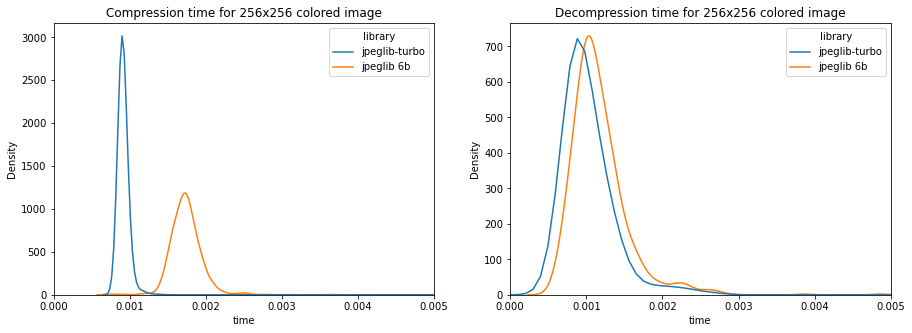

In [4]:
import tempfile
kw_c = {'qt': 75, 'flags': []}
kw_d = {'out_color_space': 'JCS_RGB', 'flags': []}

with tempfile.TemporaryDirectory() as tmp:
    fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
    
    # measure each version
    test_versions = ['6b','turbo210']
    t_c,t_d = {v:[] for v in test_versions},{v:[] for v in test_versions} # compression and decompression times
    for version in test_versions:
        with jpeglib.version(version):
            
            # iterate dataset
            for i in range(alaska.shape[0]):
                
                t = jpeglib.Timer('compression')
                im = jpeglib.from_spatial(alaska[i])
                im.samp_factor = ((1,1),(1,1),(1,1))
                im.write_spatial(fnames[i], **kw_c) # compress
                t_c[version].append(t.stop())
                
                t = jpeglib.Timer('decompression')
                #jpeglib.JPEG(fnames[i]).read_spatial(**kw_d) # decompress
                jpeglib.read_spatial(fnames[i], **kw_d).spatial # decompress
                t_d[version].append(t.stop())

# Welch's t-test
#   H0: mu_6b <= mu_turbo
#   HA: mu_6b > mu_turbo
from scipy.stats import ttest_ind, ttest_ind_from_stats
_, pc = ttest_ind(t_c['6b'], t_c['turbo210'], alternative='greater', equal_var=False)
_, pd = ttest_ind(t_d['6b'], t_d['turbo210'], alternative='greater', equal_var=False)
print('p-values: for compression %.2E, for decompression %.2E' % (pc,pd))

# plot histograms
import pandas as pd
times_c = pd.concat([pd.DataFrame({'library': 'jpeglib-turbo', 'time': t_c['turbo210']}),
                     pd.DataFrame({'library': 'jpeglib 6b', 'time': t_c['6b']}) ], ignore_index=True)
times_d = pd.concat([pd.DataFrame({'library': 'jpeglib-turbo', 'time': t_d['turbo210']}),
                     pd.DataFrame({'library': 'jpeglib 6b', 'time': t_d['6b']}) ], ignore_index=True)
import seaborn as sns
fig,ax = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=times_c, x="time", hue="library", ax=ax[0]).set_title("Compression time for 256x256 colored image");
sns.kdeplot(data=times_d, x="time", hue="library", ax=ax[1]).set_title("Decompression time for 256x256 colored image");
ax[0].set_xlim(0,.005)
ax[1].set_xlim(0,.005)
plt.show()

## Colored images

### Compression

As first we compress our randomly chosen subsamples by each version. For decompression we use one, arbitrary version to remove the potential artifacts from decompression mismatch.

In [5]:
# images recompressed by each version
import tempfile
images_rgb = {'version': [], 'image': [], 'Y': [], 'Cb': [], 'Cr': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # compress each image with version
        fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
        with jpeglib.version(v_compress):
            for i,fname in enumerate(fnames):
                im = jpeglib.from_spatial(alaska[i])
                im.write_spatial(fname)
        
        # decompress with single (arbitrary) version
        with jpeglib.version(v_arbitrary):
            images_rgb['version'].append(v_compress)
            images_rgb['image'].append(np.array([
                jpeglib.read_spatial(fname).spatial
                for fname in fnames]))
            images_rgb['Y'].append([
                jpeglib.read_dct(fname).Y for fname in fnames
            ])
            images_rgb['Cb'].append([
                jpeglib.read_dct(fname).Cb for fname in fnames
            ])
            images_rgb['Cr'].append([
                jpeglib.read_dct(fname).Cr for fname in fnames
            ])

# dataframe
import pandas as pd
images_rgb = pd.DataFrame(images_rgb)

### N-to-N comparison

Next we compare each version with each in spatial domain and construct distance matrix (triangular, as it is symmetric).

In [6]:
# distance metric (based on L1)
from scipy.spatial.distance import pdist, squareform
mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

# images to distance matrix
images_rgb_list = np.array([list(i) for i in images_rgb.image.to_list()], dtype=object)
images_rgb_list = images_rgb_list.reshape(len(versions), -1)
dists_rgb = pdist(images_rgb_list, mismatch)
distmat_rgb = squareform(dists_rgb)

We also need to compare DCT representations to validate, that compression and decompression artifacts did not removed themselves.

In [7]:
def get_distmat_dct(dct):
    # images to distance matrix
    images_dct_list = np.array([list(i) for i in dct.to_list()], dtype=object)
    images_dct_list = images_dct_list.reshape(len(versions), -1)
    dists_dct = pdist(images_dct_list, mismatch)
    distmat_dct = squareform(dists_dct)
    return distmat_dct

# check match with spatial
distmat_Y = get_distmat_dct(images_rgb.Y)
print("Y", ((distmat_rgb == 0) == (distmat_Y == 0)).all())
# check match with spatial
distmat_Cb = get_distmat_dct(images_rgb.Cb)
print("Cb", ((distmat_rgb == 0) == (distmat_Cb == 0)).all())
# check match with spatial
distmat_Cr = get_distmat_dct(images_rgb.Cr)
print("Cr", ((distmat_rgb == 0) == (distmat_Cr == 0)).all())

Y False
Cb True
Cr True


DCT representation shows the same mismatches as RGB representation.

### Clustering of spatial domain

In the next step we find clusters, corresponding to distinct implementations, which in this configuration produce different results.

In [8]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for k in range(1,6):
    agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
    agnes.fit(distmat_rgb)
    
    # compute heterogenity metric (sum of distances)
    heterogenity = np.sum([ distmat_rgb[i,j]
             for group in np.unique(agnes.labels_)
             for i in np.where(agnes.labels_ == group)[0]
             for j in np.where(agnes.labels_ == group)[0] ])
    
    # homogenous clusters
    if heterogenity == 0: break
print(k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']


We receive three clusters:

- libjpeg 6b and turbo 2.1.0
- libjpeg 7 to 9d
- libjpeg 9e

### Clustering of luminance

In [9]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for k in range(1,6):
    agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
    agnes.fit(distmat_rgb)
    
    # compute heterogenity metric (sum of distances)
    heterogenity = np.sum([ distmat_Y[i,j]
             for group in np.unique(agnes.labels_)
             for i in np.where(agnes.labels_ == group)[0]
             for j in np.where(agnes.labels_ == group)[0] ])
    
    # homogenous clusters
    if heterogenity == 0: break
print(k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']


Difference is only in chrominance channels. In luminance, all versions return the same result.

### Mismatch matrix

To confirm, we visualize the mismatch matrix, which is a distance matrix where non-zero values are set to 1.

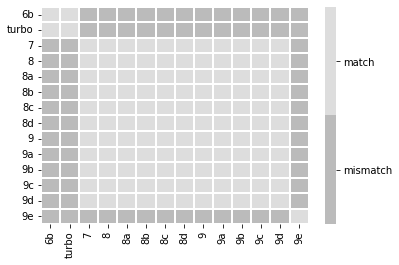

In [10]:
# create plot
fig,ax = plt.subplots(1,1)
import seaborn as sns
sns.heatmap(
    pd.DataFrame(distmat_rgb == 0, index=versions2, columns=versions2),
    linewidth=.05, ax=ax, cmap=['#BBB','#DDD'])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
colorbar.set_ticklabels(['mismatch','match'])

Mismatch matrix supports the clusters discovered before.

## Grayscale images

Now we change to BOSS database, as we will work with grayscale images.

### Compression

First we compress with parameter `in_color_space` set to grayscale.

In [14]:
# images recompressed by each version
images_gray = {'version': [], 'image': [], 'Y': []}

import tempfile
with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # compress each image with version
        fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(boss.shape[0])]
        with jpeglib.version(v_compress):
            for i,fname in enumerate(fnames):
                im = jpeglib.from_spatial(boss[i], 'JCS_GRAYSCALE')
                im.write_spatial(fname)
        
        # decompress with single (arbitrary) version
        with jpeglib.version('9d'):
            images_gray['version'].append(v_compress)
            images_gray['image'].append(np.array([
                jpeglib.read_spatial(fname).spatial for fname in fnames
            ]))
            images_gray['Y'].append([
                jpeglib.read_dct(fname).Y for fname in fnames
            ])

# dataframe
import pandas as pd
images_gray = pd.DataFrame(images_gray)

### N-to-N comparison

Then we compare all the versions and construct distance matrix.

In [15]:
# distance metric (based on L1)
from scipy.spatial.distance import pdist, squareform
pixel_mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

# images to distance matrix
images_gray_list = np.array([list(i) for i in images_gray.image.to_list()], dtype=object)
images_gray_list = images_gray_list.reshape(len(versions), -1)
dists_gray = pdist(images_gray_list, mismatch)
distmat_gray = squareform(dists_gray)

As before, we do the same for the DCT.

In [16]:
# images to distance matrix
images_dct_list = np.array([list(i) for i in images_gray.Y.to_list()], dtype=object)
images_dct_list = images_dct_list.reshape(len(versions), -1)
dists_dct = pdist(images_dct_list, mismatch)
distmat_dct = squareform(dists_dct)

# check match with spatial
((distmat_gray == 0) == (distmat_dct == 0)).all()

True

### Clustering

The distance matrix is clustered based, so that we have uniform clusters.

In [17]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for k in range(1,6):
    agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
    agnes.fit(distmat_gray)
    
    # compute heterogenity metric (sum of distances)
    heterogenity = np.sum([ distmat_gray[i,j]
             for group in np.unique(agnes.labels_)
             for i in np.where(agnes.labels_ == group)[0]
             for j in np.where(agnes.labels_ == group)[0] ])
    
    # homogenous clusters
    if heterogenity == 0: break
print(k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']


All the versions belong to the same cluster.

### Mismatch matrix

For control, we again plot the mismatch matrix.

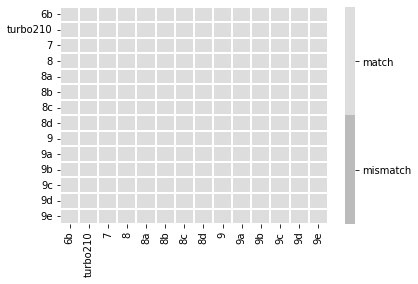

In [18]:
# create plot
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
import seaborn as sns
sns.heatmap(
    pd.DataFrame(distmat_gray == 0, index=versions, columns=versions),
    linewidth=.05, ax=ax, cmap=['#BBB','#DDD'])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
colorbar.set_ticklabels(['mismatch','match'])

Heatmap shows that all the versions behave identically.